In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from os.path import exists
from quality_match.types import TaskInput, TaskOutput, Answer


REFERENCES_DATA_PATH = '../data/references.json'
ANONYMIZED_PROJECT_DATA_PATH = '../data/anonymized_project.json'    

def get_answer_disagree_score(task_output: TaskOutput) -> int:  
    ans_map = {Answer.NO: -1, Answer.YES: 1, Answer.EMPTY: 0}
    return ans_map[task_output.answer]

def get_reference_key(task_input: TaskInput) -> str:
    return task_input.image_url.split("/")[-1].split(".")[0]

def load_normalized_data():
    if not exists(REFERENCES_DATA_PATH) or not exists(ANONYMIZED_PROJECT_DATA_PATH):
        raise Exception("Data files not found ...")
    
    references = pd.read_json(REFERENCES_DATA_PATH).T
    anonymized_project_json_file = json.load(open(ANONYMIZED_PROJECT_DATA_PATH))
    anonymized_project_data = anonymized_project_json_file['results']['root_node']['results']

    records = []
    for task_id, tasks in anonymized_project_data.items():
        for record in tasks['results']:
            record['task_id'] = task_id
            record['answer_disagree_score'] = get_answer_disagree_score(TaskOutput.from_dict(record['task_output']))
            ref_key = get_reference_key(TaskInput.from_dict(record['task_input']))        
            record['reference'] = references.loc[ref_key, 'is_bicycle']
            records.append(record)        
       
    data = pd.json_normalize(records)
    
    data.loc[data['task_output.duration_ms'] <= 0, "task_output.duration_ms"] = 0
    data.astype({'task_output.duration_ms': 'int64'}) 

    return data, references

data, references = load_normalized_data()
data

,created_at,workpackage_total_size,loss,project_node_input_id,project_node_output_id,project_root_node_input_id,task_id,answer_disagree_score,reference,task_input.image_url,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.vendor_id,user.id,user.vendor_user_id,root_input.image_url
0,2021-02-25T14:08:11.319438+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,0000439a-96ac-4bd4-8753-a4baa229ecf2,7e8984b6-dff7-4015-865a-b721a2faf681,7e8984b6-dff7-4015-865a-b721a2faf681,-1,False,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,997,vendor_01,08af8775-a72c-4c59-b60f-9ce7df04fa92,annotator_12,https://qm-auto-annotator.s3.eu-central-1.amaz...
1,2021-02-25T13:14:39.411149+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,0488b469-7c5f-459a-bfcb-ed94957c09c2,7e8984b6-dff7-4015-865a-b721a2faf681,7e8984b6-dff7-4015-865a-b721a2faf681,-1,False,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,845,vendor_01,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d,annotator_11,https://qm-auto-annotator.s3.eu-central-1.amaz...
2,2021-02-25T15:19:57.889434+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,323902a9-3b41-4885-8796-4e393aa2e0a0,7e8984b6-dff7-4015-865a-b721a2faf681,7e8984b6-dff7-4015-865a-b721a2faf681,-1,False,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,1468,vendor_01,780c974e-6ce7-4f1d-9afe-56bf96753fca,annotator_22,https://qm-auto-annotator.s3.eu-central-1.amaz...
3,2021-02-26T03:56:18.770331+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,4222ac20-7aaa-4b07-bb2b-4423bf41eefe,7e8984b6-dff7-4015-865a-b721a2faf681,7e8984b6-dff7-4015-865a-b721a2faf681,-1,False,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,1062,vendor_01,94afdf79-917c-4904-bdaa-7a121f33b0ff,annotator_17,https://qm-auto-annotator.s3.eu-central-1.amaz...
4,2021-02-25T15:39:06.644705+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,42ba767f-5bd1-4e62-aff1-4e716fd23623,7e8984b6-dff7-4015-865a-b721a2faf681,7e8984b6-dff7-4015-865a-b721a2faf681,-1,False,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,879,vendor_01,37a6036c-a9ef-4fcb-b554-7058f00415db,annotator_02,https://qm-auto-annotator.s3.eu-central-1.amaz...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90865,2021-02-25T14:50:17.777598+00:00,5,0.0,3db139c1-7fec-44b3-b770-a790bfcff241,c15c69ca-fd11-49b2-b198-d998ed1d6909,3db139c1-7fec-44b3-b770-a790bfcff241,3db139c1-7fec-44b3-b770-a790bfcff241,1,True,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,2690,vendor_01,08af8775-a72c-4c59-b60f-9ce7df04fa92,annotator_12,https://qm-auto-annotator.s3.eu-central-1.amaz...
90866,2021-02-26T04:11:29.015906+00:00,5,0.0,3db139c1-7fec-44b3-b770-a790bfcff241,e7674678-572c-4fbb-b0dd-7e43bbc6cfad,3db139c1-7fec-44b3-b770-a790bfcff241,3db139c1-7fec-44b3-b770-a790bfcff241,1,True,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1407,vendor_01,66d63556-1235-4a5e-accc-651cb2993db4,annotator_16,https://qm-auto-annotator.s3.eu-central-1.amaz...
90867,2021-02-25T13:58:18.253317+00:00,5,0.0,3db139c1-7fec-44b3-b770-a790bfcff241,ee448bd3-a93e-4586-a5a7-e3722b052d9a,3db139c1-7fec-44b3-b770-a790bfcff241,3db139c1-7fec-44b3-b770-a790bfcff241,1,True,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1293,vendor_01,08af8775-a72c-4c59-b60f-9ce7df04fa92,annotator_12,https://qm-auto-annotator.s3.eu-central-1.amaz...
90868,2021-02-25T13:02:51.311501+00:00,5,0.0,3db139c1-7fec-44b3-b770-a790bfcff241,f2859473-b7a0-4c55-b5d9-ee80fa4a75a9,3db139c1-7fec-44b3-b770-a790bfcff241,3db139c1-7fec-44b3-b770-a790bfcff241,1,True,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1306,vendor_01,9fddf227-6680-42f5-aca5-533fc439c193,annotator_04,https://qm-auto-annotator.s3.eu-central-1.amaz...


### Task 1
a. How many annotators did contribute to the dataset?

In [43]:
len(data['user.id'].unique())

22

b. What are the average, min and max annotation times (durations) ? 
Feel free to add visual representations here such as graphs if you like.

In [44]:
data['task_output.duration_ms'].describe().round(2)
# TODO: Remove outliers (negative numbers and big reported numbers)

count    90870.00
mean      1289.84
std       1124.01
min          0.00
25%        887.00
50%       1058.00
75%       1328.00
max      42398.00
Name: task_output.duration_ms, dtype: float64

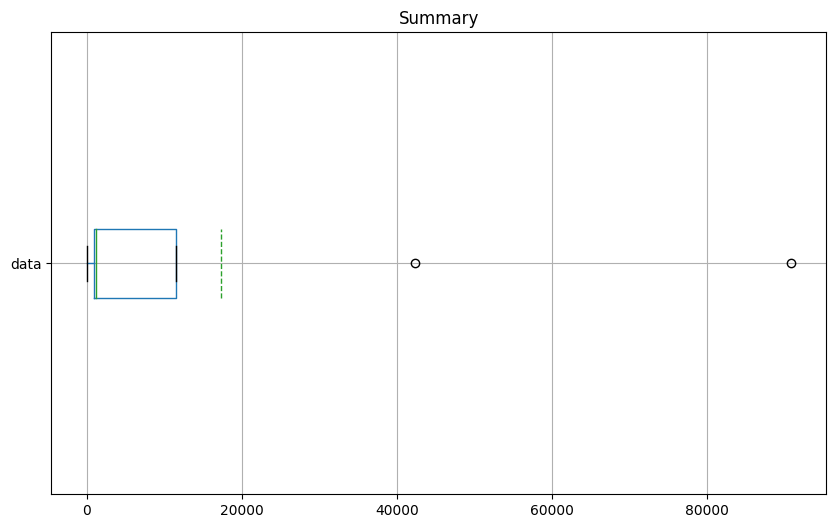

In [45]:
d = {"count": 90870.00, 'Mean': 1289.8, 'Std': 1124.011302, 'Min': 0.0, '25%': 887.0, '50%': 1058.0, '75%': 1328.0, 'Max': 42398.0}
s = pd.Series(d)

duration_plot = s.to_frame('data').boxplot(vert=False, figsize=(10,6) ,meanline=True, showmeans=True)
plt.title("Summary")
plt.show()

c. Did all annotators produce the same amount of results, or are there differences? 

In [46]:
data.groupby("user.id").agg(count=('user.id', 'count')).sort_values('count', ascending=False).reset_index()

,user.id,count
0,37a6036c-a9ef-4fcb-b554-7058f00415db,7596
1,fa6bb2a5-c7ec-4dca-aca3-b0666efa2a54,7078
2,da2b934c-6384-44ea-adcd-3de648bfae89,6537
3,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d,6436
4,9fddf227-6680-42f5-aca5-533fc439c193,6421
5,08af8775-a72c-4c59-b60f-9ce7df04fa92,6210
6,0e606b41-ebe4-4d7d-996c-db910c84971a,6126
7,75f1e1c8-d127-430f-a885-c2d126364198,6088
8,5765cc32-9e32-43e1-bd78-384cfd52d55a,5337
9,32971d11-e972-4d73-99a6-0847e1261995,5170


d. Are there questions for which annotators highly disagree?

In [47]:
# Each image appears exactly 10 times in the dataset
data.groupby('task_input.image_url').agg(count=('user.id', 'count'))['count'].unique()

array([10])

In [48]:
d1 = data.groupby("task_input.image_url").agg(sum=('answer_disagree_score', 'sum')).reset_index()
d1[d1['sum'] == 0]

,task_input.image_url,sum
391,https://qm-auto-annotator.s3.eu-central-1.amaz...,0
490,https://qm-auto-annotator.s3.eu-central-1.amaz...,0
627,https://qm-auto-annotator.s3.eu-central-1.amaz...,0
666,https://qm-auto-annotator.s3.eu-central-1.amaz...,0
669,https://qm-auto-annotator.s3.eu-central-1.amaz...,0
...,...,...
7701,https://qm-auto-annotator.s3.eu-central-1.amaz...,0
8397,https://qm-auto-annotator.s3.eu-central-1.amaz...,0
8812,https://qm-auto-annotator.s3.eu-central-1.amaz...,0
8819,https://qm-auto-annotator.s3.eu-central-1.amaz...,0


### Task 2


a.1. How often does 'corrupt_data'  occur in the project and do you see a trend within the annotators that made use of these options?

In [49]:
corrupt_data = data[data['task_output.corrupt_data'] == True]
corrupt_data[['task_output.corrupt_data', 'user.vendor_id', 'user.id']]

,task_output.corrupt_data,user.vendor_id,user.id
4194,True,vendor_01,32971d11-e972-4d73-99a6-0847e1261995
7733,True,vendor_01,5765cc32-9e32-43e1-bd78-384cfd52d55a
22669,True,vendor_01,da2b934c-6384-44ea-adcd-3de648bfae89
53442,True,vendor_01,32971d11-e972-4d73-99a6-0847e1261995


a.2. How often does 'cant_solve'  occur in the project and do you see a trend within the annotators that made use of these options?

In [50]:
cant_solve = data[data['task_output.cant_solve'] == True]
cant_solve[['task_output.corrupt_data', 'user.vendor_id', 'user.id']]
#cant_solve.groupby("user.id").agg(count=('user.id', 'count')).sort_values('count', ascending=False).reset_index()


,task_output.corrupt_data,user.vendor_id,user.id
2742,False,vendor_01,32971d11-e972-4d73-99a6-0847e1261995
3943,False,vendor_01,780c974e-6ce7-4f1d-9afe-56bf96753fca
7413,False,vendor_01,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d
11008,False,vendor_01,d40ae601-32bf-4b0c-b92c-5bd474e40c18
15243,False,vendor_01,9fddf227-6680-42f5-aca5-533fc439c193
15738,False,vendor_01,da2b934c-6384-44ea-adcd-3de648bfae89
19432,False,vendor_01,da2b934c-6384-44ea-adcd-3de648bfae89
47485,False,vendor_01,b04e6596-24c3-4e0b-b96a-4a6d78c04b40
47867,False,vendor_01,9fddf227-6680-42f5-aca5-533fc439c193
48951,False,vendor_01,9fddf227-6680-42f5-aca5-533fc439c193


### Task 3

Is the reference set balanced? Please demonstrate via numbers and visualizations.

In [51]:
counts = references['is_bicycle'].value_counts()
counts

True     4586
False    4501
Name: is_bicycle, dtype: int64

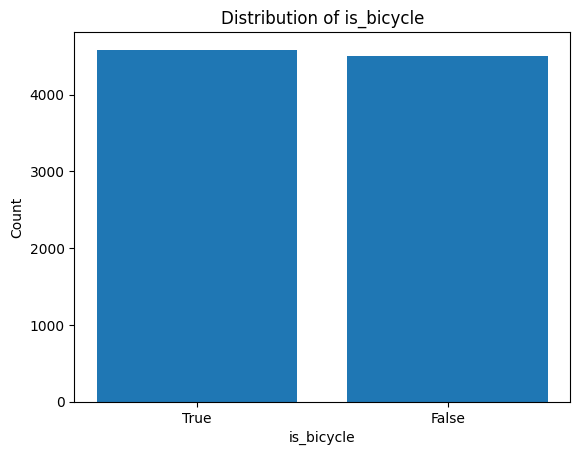

In [52]:
plt.bar(counts.index.astype(str), counts.values)
plt.title('Distribution of is_bicycle')
plt.xlabel('is_bicycle')
plt.ylabel('Count')
plt.show()

### Task 4

Using the reference set, can you identify good and bad annotators? Please use statistics and visualizations. Feel free to get creative.

to identify the good / bad annotator we can consider the following approach:
1. Calculate the accuracy of each annotator (number of correct answer / total number).
2. Determine a threshold for what constitutes a good annotator versus a bad annotator.

In [53]:
def check_answer(rec):
    if rec['task_output.answer']:
        if rec['task_output.answer'] == 'yes' and rec['reference'] is True:
            return True
        if rec['task_output.answer'] == 'no' and rec['reference'] is False:
            return True
    return False


bad_annotations = data[data.apply(lambda rec: not check_answer(rec) , axis=1)].groupby('user.id').agg(count=('user.id', 'count')).sort_values('count', ascending=False).reset_index()
good_annotations = data[data.apply(lambda rec: check_answer(rec) , axis=1)].groupby('user.id').agg(count=('user.id', 'count')).sort_values('count', ascending=False).reset_index()

users = data.groupby('user.id').agg(count=('user.id', 'count')).sort_values('count', ascending=False).reset_index()

users['bad_annotation_count'] = bad_annotations['count']
users['good_annotation_count'] = good_annotations['count']
users['accuracy_rate'] = (users['good_annotation_count'] / users['count'])
users['error_rate'] = (users['bad_annotation_count']/ users['count']) 
sorted_accuracy = users.sort_values("accuracy_rate", ascending=False)
sorted_accuracy


,user.id,count,bad_annotation_count,good_annotation_count,accuracy_rate,error_rate
18,44629999-ab8a-4871-b4d3-4f92c3058161,1280,66,1214,0.948438,0.051562
7,75f1e1c8-d127-430f-a885-c2d126364198,6088,329,5774,0.948423,0.054041
21,b44e310d-7985-41a0-b764-034b711c75ca,170,9,161,0.947059,0.052941
1,fa6bb2a5-c7ec-4dca-aca3-b0666efa2a54,7078,495,6702,0.946878,0.069935
17,b04e6596-24c3-4e0b-b96a-4a6d78c04b40,1725,92,1633,0.946667,0.053333
6,0e606b41-ebe4-4d7d-996c-db910c84971a,6126,376,5774,0.942540,0.061378
10,66d63556-1235-4a5e-accc-651cb2993db4,5061,314,4769,0.942304,0.062043
16,780c974e-6ce7-4f1d-9afe-56bf96753fca,1745,101,1644,0.942120,0.057880
12,94afdf79-917c-4904-bdaa-7a121f33b0ff,3485,219,3283,0.942037,0.062841
14,70b9b917-b4f2-4ed1-b8f9-f3492f980103,2950,185,2773,0.940000,0.062712


In [54]:
threshold = 0.90
users['annotation_quality'] = users['good_annotation_count'] / users['count'] >= threshold
users

,user.id,count,bad_annotation_count,good_annotation_count,accuracy_rate,error_rate,annotation_quality
0,37a6036c-a9ef-4fcb-b554-7058f00415db,7596,659,7101,0.934834,0.086756,True
1,fa6bb2a5-c7ec-4dca-aca3-b0666efa2a54,7078,495,6702,0.946878,0.069935,True
2,da2b934c-6384-44ea-adcd-3de648bfae89,6537,461,6026,0.921830,0.070522,True
3,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d,6436,436,5960,0.926041,0.067744,True
4,9fddf227-6680-42f5-aca5-533fc439c193,6421,410,5878,0.915434,0.063853,True
5,08af8775-a72c-4c59-b60f-9ce7df04fa92,6210,392,5809,0.935427,0.063124,True
6,0e606b41-ebe4-4d7d-996c-db910c84971a,6126,376,5774,0.942540,0.061378,True
7,75f1e1c8-d127-430f-a885-c2d126364198,6088,329,5774,0.948423,0.054041,True
8,5765cc32-9e32-43e1-bd78-384cfd52d55a,5337,324,4945,0.926550,0.060708,True
9,32971d11-e972-4d73-99a6-0847e1261995,5170,317,4841,0.936364,0.061315,True


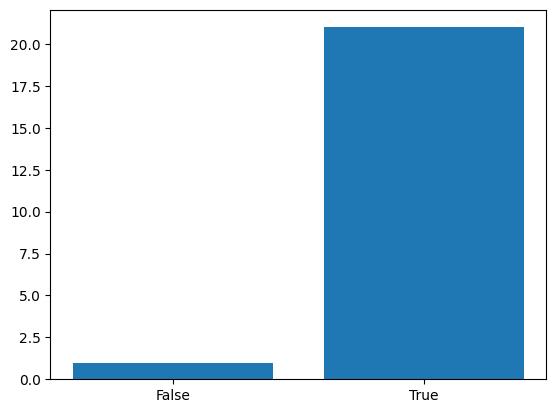

In [55]:
df = users.groupby("annotation_quality").agg(count=('user.id', 'count')).reset_index()

plt.bar(df['annotation_quality'].astype(str), df['count'])
plt.show()